<a href="https://colab.research.google.com/github/sariold/BitGold/blob/main/BitGold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\
# **BitGold - a Deep Learning Project using LSTM, a RNN for Time Series Forecasting**

---

*Bitcoin has been argued to be the next digital gold, but is it a safe and worthy store of value like its counterpart or is it simply a volatile investment?*

![TP](https://c.tenor.com/XspKDzYsphsAAAAC/bitcoin.gif)

by [Diego Sariol](https://github.com/sariold)

---


### What is a LSTM Model?


*Run the code below to watch a 3 minute video from Matlab, explaining how a RNN and LSTM work.*


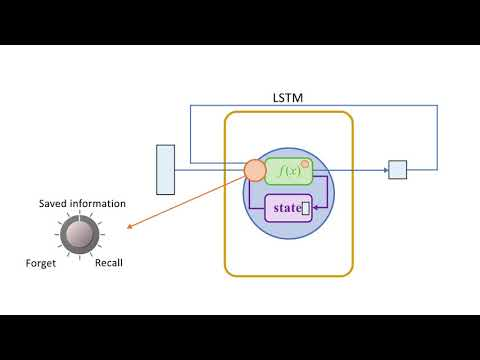

In [ ]:
from IPython.display import YouTubeVideo
# https://www.youtube.com/watch?v=5dMXyiWddYs&list=LL&index=2
YouTubeVideo('5dMXyiWddYs')

---

## Setup / Installation

Install / upgrade required dependencies to utilize the latest API library for Yahoo Finance and performing technical analysis on assets.

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install ta

     |████████████████████████████████| 109 kB 33.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28985 sha256=58361b231dc15fa3f58882de2aa95a99090f5b9a868b114366c2df3911e4f07c
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully built ta


Import libraries to be used throughout this notebook.

In [ ]:
# Mathematical libraries for matrix manipulation, plotting, calculating 
# square root, and performing technical analysis on stock info.
import numpy as np
from math import sqrt
from matplotlib import pyplot
import ta

# Pandas dataframe library which allows for dataframes to be easily 
# constructed and manipulated
import pandas as pd
import datetime as dt
import pandas_datareader.data as web

# Plotly library to create beautiful graphical and interactive plots
import plotly.express as px
import plotly.graph_objects as go

# Machine learning model creation and analysis tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

# Get NYSE Time Zone (EST)
from pytz import timezone

---

## Dataframe Creation

Setting start and end dates.

In [ ]:
start = dt.datetime(2018, 1, 1)

# NYSE date information
tz = timezone('EST')
end = dt.datetime.now(tz).date() - dt.timedelta(days = 1)

print(end)

2022-05-01


Two functions to create a dataframe from ticker information and then to merge all of the dataframes together.

In [ ]:
def make_dataframe(ticker, name):
  
    # Collecting both OPEN and CLOSE values
    tickers = pd.DataFrame(web.DataReader([ticker], 'yahoo', start, end)
    [['Open', 'Close']])

    tickers = tickers.rename(columns = {ticker : name})
    tickers = tickers.reset_index()

    # Renaming OPEN and CLOSE columns to 4 AM and 4 PM respectively to label
    # bi-daily ticker information
    tickers = tickers.rename({'Open' : '04:00:00.000000', 
                                        'Close' : '16:00:00.000000'}, 
                                      axis = 'columns')

    tickers = pd.melt(tickers, id_vars = ['Date'], 
                value_name = name).sort_values(by = ['Date'])

    # Converting the time columns back to Date index
    tickers.index = pd.to_datetime(tickers['Date'].astype(str) + " " 
                                        + tickers['Attributes'].astype(str))
    tickers = tickers.drop(columns = ['Date', 'Attributes', 'Symbols'])
    return tickers.sort_index()

# Merging all of the dataframes
def merge_dataframes(tickers):
    dfs = []
    for i in range(len(tickers)):
      dfs.append(make_dataframe(*tickers[i]))
    return dfs[0].join(dfs[1:]).fillna(method = 'ffill')

Create one huge dataframe of all of the following tickers and then calculate RSI (7 bi-daily) values for Bitcoin prices.


In [ ]:
btc = ('BTC-USD', 'BTC')
gold = ('GC=F', 'GOLD')
sp500 = ('^GSPC', 'S&P500')
wti = ('CL=F', 'WTI')
vix = ('^VIX', 'VIX')
tickers = [btc, gold, sp500, wti, vix]

# Calling the merge dataframes function to create dataframes for each 
# individual ticker and merge final result
tickers_OC = merge_dataframes(tickers)

# Calculate RSI value for Bitcoin and append to dataframe
tickers_OC['BTC-RSI'] = ta.momentum.rsi(tickers_OC['BTC'], window = 14, 
                                        fillna = False)

# Remove NAN rows
tickers_OC = tickers_OC.dropna()

# Remove first row to maintain bi-daily order
tickers_OC = tickers_OC.iloc[1: , :]

# Showing a small excerpt of the merged dataframe of all of the tickers above
print(tickers_OC)

                              BTC         GOLD       S&P500         WTI  \
2018-01-08 04:00:00  16476.199219  1319.900024  2742.669922   61.610001   
2018-01-08 16:00:00  15170.099609  1318.599976  2747.709961   61.730000   
2018-01-09 04:00:00  15123.700195  1309.599976  2751.149902   61.919998   
2018-01-09 16:00:00  14595.400391  1311.699951  2751.290039   62.959999   
2018-01-10 04:00:00  14588.500000  1320.300049  2745.550049   63.410000   
...                           ...          ...          ...         ...   
2022-04-30 16:00:00  37714.875000  1909.300049  4131.930176  104.690002   
2022-05-01 04:00:00  37713.265625  1909.300049  4131.930176  104.690002   
2022-05-01 16:00:00  38469.093750  1909.300049  4131.930176  104.690002   
2022-05-02 04:00:00  38491.511719  1909.300049  4131.930176  104.690002   
2022-05-02 16:00:00  38499.042969  1909.300049  4131.930176  104.690002   

                           VIX    BTC-RSI  
2018-01-08 04:00:00   9.610000  65.626710  
2018-01-08 

---

## Chart Plotting

Generate an interactive Bitcoin price chart.

In [ ]:
trace_BTC = go.Scatter(
    x = tickers_OC.index,
    y = tickers_OC['BTC'],
    mode = 'lines',
    name = 'Ground Truth'
)

layout = go.Layout(
    title = 'Bitcoin',
    xaxis = dict(
        rangeselector = dict(
           buttons = list([
            dict(count = 1, label = '1M', step = 'month', 
                 stepmode = 'backward'),
            dict(count = 6, label = '6M', step = 'month', 
                 stepmode = 'backward'),
            dict(count = 1, label = 'YTD', step = 'year', 
                 stepmode = 'todate'),
            dict(count = 1, label = '1Y', step = 'year', 
                 stepmode = 'backward'),
            dict(step = 'all')])),
        title = 'Date',
        showspikes = True),
    yaxis = {'title' : 'Price', 'tickprefix' : '$', 'showspikes' : True}
)

fig = go.Figure(data = [trace_BTC], layout = layout)

fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)

fig['layout']['title']['font'] = dict(size=25)

fig.show(renderer = 'colab')

Relative Strength Index graphical explanation below.

![TP](https://i.ytimg.com/vi/VH84ppzmq9Q/maxresdefault.jpg)

Generate an interactive Bitcoin RSI value chart.

In [ ]:
trace_RSI = go.Scatter(
    x = tickers_OC.index,
    y = tickers_OC['BTC-RSI'],
    mode = 'lines',
    name = 'Ground Truth'
)

layout = go.Layout(
    title = 'RSI of Bitcoin',
    xaxis = dict(
        rangeselector = dict(
           buttons = list([
            dict(count = 1, label = '1M', step = 'month', 
                 stepmode = 'backward'),
            dict(count = 6, label = '6M', step = 'month', 
                 stepmode = 'backward'),
            dict(count = 1, label = 'YTD', step = 'year', 
                 stepmode = 'todate'),
            dict(count = 1, label = '1Y', step = 'year', 
                 stepmode = 'backward'),
            dict(step = 'all')])),
        title = 'Date',
        showspikes = True),
    yaxis = {'title' : 'Value', 'showspikes' : True}
)

fig = go.Figure(data = [trace_RSI], layout = layout)

fig.add_hrect(
        y0 = 0, y1 = 30, line_width = 0, 
        fillcolor = 'green', opacity = 0.2,  annotation_text = 'BUY', 
        annotation_position = 'bottom right')
fig.add_hrect(
        y0 = 70, y1 = 100, line_width = 0, 
        fillcolor = 'red', opacity = 0.2,  annotation_text = 'SELL', 
        annotation_position = 'top right')

fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)

fig['layout']['title']['font'] = dict(size=25)

fig.show(renderer = 'colab')

Generate an interactive Gold price chart.

In [ ]:
trace_GOLD = go.Scatter(
    x = tickers_OC.index,
    y = tickers_OC['GOLD'],
    mode = 'lines',
    name = 'Ground Truth'
)

layout = go.Layout(
    title = 'Gold',
    xaxis = dict(
        rangeselector = dict(
           buttons = list([
            dict(count = 1, label = '1M', step = 'month', 
                 stepmode = 'backward'),
            dict(count = 6, label = '6M', step = 'month', 
                 stepmode = 'backward'),
            dict(count = 1, label = 'YTD', step = 'year', 
                 stepmode = 'todate'),
            dict(count = 1, label = '1Y', step = 'year', 
                 stepmode = 'backward'),
            dict(step = 'all')])),
        title = 'Date',
        showspikes = True),
    yaxis = {'title' : 'Price', 'tickprefix' : '$', 'showspikes' : True}
)

fig = go.Figure(data = [trace_GOLD], layout = layout)

fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)

fig['layout']['title']['font'] = dict(size=25)

fig.show(renderer = 'colab')

Generate an interactive Volatility Index value chart.

In [ ]:
trace_VIX = go.Scatter(
    x = tickers_OC.index,
    y = tickers_OC['VIX'],
    mode = 'lines',
    name = 'Ground Truth'
)

layout = go.Layout(
    title = 'Chicago Board Options Exchange Volatility Index',
    xaxis = dict(
        rangeselector = dict(
           buttons = list([
            dict(count = 1, label = '1M', step = 'month', 
                 stepmode = 'backward'),
            dict(count = 6, label = '6M', step = 'month', 
                 stepmode = 'backward'),
            dict(count = 1, label = 'YTD', step = 'year', 
                 stepmode = 'todate'),
            dict(count = 1, label = '1Y', step = 'year', 
                 stepmode = 'backward'),
            dict(step = 'all')])),
        title = 'Date',
        showspikes = True),
    yaxis = {'title' : 'Value', 'showspikes' : True}
)

fig = go.Figure(data = [trace_VIX], layout = layout)

fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)

fig['layout']['title']['font'] = dict(size=25)

fig.show(renderer = 'colab')

Generate an interactive S&P500 price chart.

In [ ]:
trace_SP = go.Scatter(
    x = tickers_OC.index,
    y = tickers_OC['S&P500'],
    mode = 'lines',
    name = 'Ground Truth'
)

layout = go.Layout(
    title = "Standard and Poor's 500",
    xaxis = dict(
        rangeselector = dict(
           buttons = list([
            dict(count = 1, label = '1M', step = 'month', 
                 stepmode = 'backward'),
            dict(count = 6, label = '6M', step = 'month', 
                 stepmode = 'backward'),
            dict(count = 1, label = 'YTD', step = 'year', 
                 stepmode = 'todate'),
            dict(count = 1, label = '1Y', step = 'year', 
                 stepmode = 'backward'),
            dict(step = 'all')])),
        title = 'Date',
        showspikes = True),
    yaxis = {'title' : 'Price', 'tickprefix' : '$', 'showspikes' : True}
)
fig = go.Figure(data = [trace_SP], layout = layout)

fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)

fig['layout']['title']['font'] = dict(size=25)

fig.show(renderer = 'colab')

Generate an interactive WTI Crude Oil price chart.

In [ ]:
trace_WTI = go.Scatter(
    x = tickers_OC.index,
    y = tickers_OC['WTI'],
    mode = 'lines',
    name = 'Ground Truth'
)

layout = go.Layout(
    title = 'West Texas Intermediate Crude Oil',
    xaxis = dict(
        rangeselector = dict(
           buttons = list([
            dict(count = 1, label = '1M', step = 'month', 
                 stepmode = 'backward'),
            dict(count = 6, label = '6M', step = 'month', 
                 stepmode = 'backward'),
            dict(count = 1, label = 'YTD', step = 'year', 
                 stepmode = 'todate'),
            dict(count = 1, label = '1Y', step = 'year', 
                 stepmode = 'backward'),
            dict(step = 'all')])),
        title = 'Date',
        showspikes = True),
    yaxis = {'title' : 'Price', 'tickprefix' : '$', 'showspikes' : True}
)

fig = go.Figure(data = [trace_WTI], layout = layout)

fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)

fig['layout']['title']['font'] = dict(size=25)

fig.show(renderer = 'colab')

---

## Model Preparation

Transform the 'tickers_OC' matrix series into a supervised series. This means converting the matrix into a matrix containing predecessive steps of all multi-variate values and a final output of the resulting values.

### Series to Supervised

```
[[1, 2, 3, 4], <- day 1 data

[5, 6, 7, 8], <- day 2 data

[9, 10, 11, 12]] <- day 3 data

becomes

[1, 2, 3, 4, 5, 6, 7, 8] <- input data

[9, 10, 11, 12] <- output data
```

Normalizing all of the data between '0' and '1' in order to begin transforming the series into a supervised one. The next step is to split the supervised series into the corresponding 'test' and 'train' matrices.

In [ ]:
dataset = tickers_OC.values

# Normalizing all of the data
values = dataset
values = values.astype('float32')
scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

dataset = scaled

### LSTM Code Citation

Jason Brownlee, How to Develop LSTM Models for Time Series Forecasting
, Available from https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/, accessed February 20th, 2022.

In [ ]:
# CODE FROM LSTM TUTORIAL -> BEGIN

# Split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
		X, Y = list(), list()
		for i in range(len(sequences)):

				# Find the end of this pattern
				end_ix = i + n_steps

				# Check if we are beyond the dataset
				if end_ix > len(sequences)-1:
						break

				# Gather input and output parts of the pattern
				seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
				X.append(seq_x)
				Y.append(seq_y)
		return np.array(X), np.array(Y)
 
# CODE FROM LSTM TUTORIAL -> END

Calling function to transform series to supervised series and splitting the data into corresponding X and Y test and train data sets.

In [ ]:
# Amount of data points for look back
n_steps = 10
X, Y = split_sequences(dataset, n_steps)

# Splitting the data
split_percent = 0.85
split = int(split_percent*len(dataset))
trainX = X[:split, :]
testX = X[split:, :]

trainY = Y[:split, :]
testY = Y[split:, :]

# Amount of input variables
n_features = X.shape[2]

Creating the LSTM model and training it on train data in order to perform an evaluation on the test data.



In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, 
               input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
history = model.fit(trainX, trainY, epochs=10000, batch_size=1024, 
                    validation_data=(testX, testY), verbose=2, shuffle=False)

# Model prediction on testX data set
yhat = model.predict(testX)

# Inverse scaling
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(testY)

# Calculating Root Mean Squared Error to determine difference between loss and 
# val loss
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Streaming output truncated to the last 5000 lines.
3/3 - 0s - loss: 3.5661e-04 - val_loss: 0.0092 - 163ms/epoch - 54ms/step
Epoch 7502/10000
3/3 - 0s - loss: 3.5997e-04 - val_loss: 0.0095 - 147ms/epoch - 49ms/step
Epoch 7503/10000
3/3 - 0s - loss: 3.9011e-04 - val_loss: 0.0090 - 159ms/epoch - 53ms/step
Epoch 7504/10000
3/3 - 0s - loss: 4.0440e-04 - val_loss: 0.0093 - 157ms/epoch - 52ms/step
Epoch 7505/10000
3/3 - 0s - loss: 4.3061e-04 - val_loss: 0.0087 - 149ms/epoch - 50ms/step
Epoch 7506/10000
3/3 - 0s - loss: 4.3730e-04 - val_loss: 0.0097 - 151ms/epoch - 50ms/step
Epoch 7507/10000
3/3 - 0s - loss: 4.1156e-04 - val_loss: 0.0090 - 140ms/epoch - 47ms/step
Epoch 7508/10000
3/3 - 0s - loss: 4.0588e-04 - val_loss: 0.0093 - 161ms/epoch - 54ms/step
Epoch 7509/10000
3/3 - 0s - loss: 3.8722e-04 - val_loss: 0.0089 - 200ms/epoch - 67ms/step
Epoch 7510/10000
3/3 - 0s - loss: 4.0627e-04 - val_loss: 0.0084 - 158ms/epoch - 53ms/step
Epoch 7511/10000
3/3 - 0s - loss: 4.2523e-04 - val_loss: 0.0101 - 

<!-- ## Model -->

Generate an interactive Loss vs. Val Loss value chart.

In [ ]:
trace_train =  go.Scatter(
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train'
)

trace_test =  go.Scatter(
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test'
)

layout = go.Layout(
    title = 'Loss vs. Val Loss',
    xaxis = {'title' : 'Epochs'},
    yaxis = {'title' : 'Value'},
    hovermode = 'x'
)

fig = go.Figure(data = [trace_train, trace_test], layout = layout)

fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)

fig['layout']['title']['font'] = dict(size=25)

fig.show(renderer = 'colab')

Generate an interactive Actual vs. Predicted price chart.

In [ ]:
predicted_BTC = inv_yhat[:, :1].flatten()

trace_actual =  go.Scatter(
    x = tickers_OC.index,
    y = tickers_OC['BTC'],
    mode = 'lines',
    name = 'Actual'
)

trace_predicted =  go.Scatter(
    x = tickers_OC.index[split:],
    y = predicted_BTC,
    mode = 'lines',
    name = 'Predicted'
)

layout = go.Layout(
    title = 'Bitcoin Training and Test Prediction',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'Price', 'tickprefix' : '$', 'showspikes' : True},
    hovermode = 'x'
)

fig = go.Figure(data = [trace_actual, trace_predicted], layout = layout)

fig.add_vrect(x0=tickers_OC.index[0], x1=tickers_OC[:split].index[-1], 
              annotation_text="TRAINING",
              fillcolor="green", opacity=0.25, line_width=0)

fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)

fig['layout']['title']['font'] = dict(size=25)

fig.show(renderer = 'colab')

Revealing the model's information to better understand the architecture.

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 100)           42800     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 6)                 606       
                                                                 
Total params: 123,806
Trainable params: 123,806
Non-trainable params: 0
_________________________________________________________________


---

## Forecasting

Saving the model as 'bitgold-[today's date].h5' to be able to reuse it later on.

In [ ]:
model.save("bitgold-" + str(dt.datetime.now().date()) + ".h5")

Loading the model saved above or a downloaded model. This code snippet is included to allow for loading a model without having to run the training code every time.

In [ ]:
del model
model = load_model("bitgold-" + str(dt.datetime.now().date()) + ".h5")
# model = load_model("final.h5")

Prediction function to utilize RNN aspect. Predict tomorrow's price plus the other variables (tickers). Append this prediction to the previous dataframe and transform back to a supervised problem and predict the following bi-daily prices plus the other variables. Rinse and repeat for N amount of days.

In [ ]:
def predict(num_prediction, model, set):
    prediction_list = []
    
    # Begin prediction for loop
    for _ in range(num_prediction):
        X, Y = split_sequences(set, n_steps)
        out = model.predict(X[-1:])

        # Append new prediction into scaled dataframe to begin next prediction
        set = np.concatenate((set, out), axis = 0)
        inv_out = scaler.inverse_transform(out)

        # Append actual price prediction into prediction_list
        inv_out = inv_out[:,0]
        prediction_list = np.append(prediction_list, inv_out)
    return prediction_list

***Forecasting*** next *N* days of Bitcoin prices.

Generate an interactive Bitcoin future forecast price chart.

In [ ]:
days_forward = 100 * 2

# Create a dataframe for forecasted values 'BTC-Predicted'
forecast_df = pd.DataFrame(data = predict(days_forward, model, dataset), 
                           columns = ['BTC-Forecast'])

# Create date range to set as forecast dateframe index in order to plot
forecast_df.index = pd.date_range(start = tickers_OC.index[-1] 
                                  + dt.timedelta(hours = 12), periods = 
                                  days_forward, freq = '12H').to_pydatetime()

trace_actual = go.Scatter(
    x = tickers_OC.index[split:], 
    y = tickers_OC['BTC'][split:],
    mode = 'lines',
    name = 'Ground Truth'
)

trace_forecast = go.Scatter(
    x = forecast_df.index,
    y = forecast_df['BTC-Forecast'],
    mode = 'lines',
    name = 'Forecasted'
)

layout = go.Layout(
    title = 'Bitcoin Forecast (100 Days Forward)',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'Price', 'tickprefix' : '$', 'showspikes' : True},
    hovermode = 'x'
)

fig = go.Figure(data = [trace_actual, trace_forecast], layout = layout)

# fig.add_vrect(x0=tickers_OC.index[0], x1=tickers_OC[:split].index[-1], 
#               annotation_text="TRAINING",
#               fillcolor="green", opacity=0.25, line_width=0)

fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)

fig['layout']['title']['font'] = dict(size=25)

fig.show(renderer = 'colab')

---

## Trading

In order to properly test the Bitcoin forecasting model, a trading excercise can be performed.

In [ ]:
# Look back of 400 data points -> 200 days
look_back = 400

# Amount of forecasted values to be predicted 
look_forward = 10
forecast = []

date_index = pd.date_range(start = tickers_OC.index[-look_back] 
                                  + dt.timedelta(hours = 12), periods = 
                                  look_back, freq = '12H').to_pydatetime()

# Begin forecasting and appending predictions to a list
while(look_back > 0):
    temp_forecast = predict(look_forward, model, dataset[:-look_back])
    forecast = np.append(forecast, temp_forecast)
    look_back -= look_forward

# Create a dataframe for forecasted values 'BTC-Predicted'
forecast_df = pd.DataFrame(data = forecast, columns = ['BTC-Forecast'])

# Create date range to set as forecast dateframe index in order to plot
forecast_df.index = date_index

trace_actual = go.Scatter(
    x = tickers_OC.index[split:], 
    y = tickers_OC['BTC'][split:],
    mode = 'lines',
    name = 'Ground Truth'
)

trace_forecast = go.Scatter(
    x = forecast_df.index,
    y = forecast_df['BTC-Forecast'],
    mode = 'lines',
    name = 'Forecasted'
)

layout = go.Layout(
    title = 'Bitcoin Forecast (200 Days Back)',
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : 'Price', 'tickprefix' : '$', 'showspikes' : True},
    hovermode = 'x'
)

fig = go.Figure(data = [trace_actual, trace_forecast], layout = layout)

# fig.add_vrect(x0=tickers_OC.index[0], x1=tickers_OC[:split].index[-1], 
#               annotation_text="TRAINING",
#               fillcolor="green", opacity=0.25, line_width=0)

fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)

fig['layout']['title']['font'] = dict(size=25)

fig.show(renderer = 'colab')

IF ELSE Trading flow chart. Only executes trades if price difference percentage is high enough and previous Bitcoin RSI value suggests a trade.

Trading algorithm which relies currently on the rules defined in the flow chart above.

In [ ]:
# Buy or Sell trading function
def buy_or_sell(cash, btc, forecast, original):
    price = original['BTC']
    look_back = len(forecast)
    cash_list, btc_list = [], []

    for i in range(0, look_back + 10, 10):
      cash_list = np.append(cash_list, cash)
      btc_list = np.append(btc_list, btc * price[:-(look_back)][-1])
      look_back = (look_back if i == 0 else len(forecast) - i)

      if(look_back <= 0): return cash, btc, cash_list, btc_list

      # Calculating price difference, whether it is positive or negative 
      percentage_increase = ((np.mean(forecast[i - 1]) - 
                    price[:-(look_back)][-1]) / price[:-(look_back)][-1]) * 100

      # Trades based on price difference percentage and previous RSI value
      if(percentage_increase <= -10 and 
         original['BTC-RSI'][:-look_back][-1] >= 70):
          cash, btc = sell_btc(cash, btc, price[:-(look_back)][-1], btc * 0.75)
          print("SELL")

      elif(percentage_increase >= 10 and 
           original['BTC-RSI'][:-look_back][-1] <= 30):
          cash, btc = buy_btc(cash, btc, price[:-(look_back)][-1], cash * 0.75)
          print("BUY")
          
      else: 
          print("HOLD")
    return cash, btc, cash_list, btc_list


# Buy Bitcoin amount and update cash / BTC wallet
def buy_btc(cash, btc, bitcoin_price, value):
    return cash - value, btc + (value / bitcoin_price)


# Sell Bitcoin amount and update cash / BTC wallet
def sell_btc(cash, btc, bitcoin_price, value):
    return cash + (value * bitcoin_price), btc - value

Perform a trading test on the forecasted prices and see how well the model can perform.

In [ ]:
# Starting amount of Cash (USD) and BTC (SATOSHIS)
cash_wallet = 5000
btc_wallet = 0

print("\starting amount")
print(cash_wallet, btc_wallet)

# Invest in Bitcoin
cash_wallet, btc_wallet = buy_btc(cash_wallet, btc_wallet, 
                                  tickers_OC['BTC'][:-400][-1], cash_wallet)

# Run trading algorithm with forecasted prices and previous real prices
cash_wallet, btc_wallet, cash_list, btc_list = buy_or_sell(cash_wallet, 
                          btc_wallet, forecast_df['BTC-Forecast'], tickers_OC)

# Sell all Bitcoin
cash_wallet, btc_wallet = sell_btc(cash_wallet, btc_wallet, 
                                   tickers_OC['BTC'][-1], btc_wallet)

print("\nfinal amount")
print(cash_wallet, btc_wallet)

cash_list = np.append(cash_list, cash_wallet)
btc_list = np.append(btc_list, 0)

\starting amount
5000 0
SELL
SELL
HOLD
HOLD
HOLD
SELL
HOLD
HOLD
HOLD
HOLD
HOLD
HOLD
HOLD
HOLD
HOLD
HOLD
HOLD
HOLD
HOLD
HOLD
BUY
HOLD
HOLD
SELL
HOLD
HOLD
BUY
HOLD
HOLD
HOLD
HOLD
HOLD
HOLD
SELL
HOLD
HOLD
HOLD
HOLD
HOLD
HOLD

final amount
6769.897411633509 0.0


Generate an interactive Cash vs. BTC value chart.

In [ ]:
trace_actual = go.Scatter(
    x = np.array(range(0, 210, 5)),
    y = cash_list,
    mode = 'markers',
    name = 'Cash Wallet'
)

trace_btc = go.Scatter(
    x = np.array(range(0, 210, 5)),
    y = btc_list,
    mode = 'lines+markers',
    name = 'BTC Wallet'
)

layout = go.Layout(
    title = 'Bitcoin Trading Results (200 Days Back)',
    xaxis = {'title' : 'Days'},
    yaxis = {'title' : 'USD', 'tickprefix' : '$'},
    hovermode = 'x'
)

fig = go.Figure(data = [trace_actual, trace_btc], layout = layout)

fig.add_annotation(x=0,
                   y=cash_list[0],
                   text = cash_list[0],
                   showarrow = True
)

fig.add_annotation(x=205,
                   y=cash_list[41],
                   text = cash_list[41],
                   showarrow = True,
)

fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)

fig['layout']['title']['font'] = dict(size=25)

fig.show(renderer = 'colab')

---

# **HAPPY INVESTING!**
*not financial advice*

![TP](https://thumbs.gfycat.com/RapidNextHamster-size_restricted.gif)
